In [10]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RepeatedKFold, train_test_split
from xgboost import XGBRegressor, DMatrix
import shap
import lightgbm as lgb
import time
import functools
shap.initjs()

In [2]:
DIRECTORY = './data/'

def timeit(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} took {end_time - start_time:.6f} seconds")
        return result
    return wrapper

In [3]:
@timeit
def fe_date(df):
    df['year'] = df['date'].dt.year
    df['day_of_week'] = df['date'].dt.dayofweek
    df['days_since_2020'] = (df['date'] - pd.to_datetime('2020-01-01')).dt.days.astype('int')
    df['day_of_year'] = df['date'].dt.dayofyear
    df['cos_day'] = np.cos(df['day_of_year']*2*np.pi/365)
    df['sin_day'] = np.sin(df['day_of_year']*2*np.pi/365)
    return df

@timeit
def fe_other(df):
    discount_cols = ['type_0_discount','type_1_discount','type_2_discount','type_3_discount','type_4_discount','type_5_discount','type_6_discount']
    df[discount_cols] = df[discount_cols].clip(0)
    df['max_discount'] = df[['type_0_discount','type_1_discount','type_2_discount','type_3_discount','type_4_discount','type_5_discount']].max(axis=1)
    
    # Given that we're using XGBoost, which is in theory invariant to monotonic transformations of features, this transformation in isolation doesn't really do anything. I mainly did it because it made the shap plot look more linear. However, I think it did make further feature engineering that used price more effective.
    df['sell_price_main'] = np.log(df['sell_price_main']) 

    df['common_name'] = df['name'].apply(lambda x: x[:x.find('_')])
    df['CN_total_products'] = df.groupby(['date','warehouse','common_name'])['unique_id'].transform('nunique')
    df['CN_discount_avg'] = df.groupby(['date','warehouse','common_name'])['max_discount'].transform('mean')
    df['CN_WH'] = df['common_name'] + '_' + df['warehouse']
    df['name_num_warehouses'] = df.groupby(['date','name'])['unique_id'].transform('nunique')
    return df

@timeit
def fe_combined(df):
    df['num_sales_days_28D'] = pd.MultiIndex.from_frame(df[['unique_id','date']]).map(df.sort_values('date').groupby('unique_id').rolling(
        window='28D', on='date', closed='left')['date'].count().fillna(0))

    # This 'price_detrended' feature was one I found pretty late into the game, but I think it helped out a lot. I was trying to make a feature that captured whether an item was cheap or expensive relative to its usual price, which is what 'price_scaled' represents. What I found was that the prices of things generally increase over time. So I removed that time-based trend to construct price_detrended, and that proved very effective.
    mean_prices = df.groupby(df['unique_id'])['sell_price_main'].mean()
    std_prices = df.groupby(df['unique_id'])['sell_price_main'].std()
    df['price_scaled'] = np.where(df['unique_id'].map(std_prices) == 0, 0, 
                                  (df['sell_price_main'] - df['unique_id'].map(mean_prices))/df['unique_id'].map(std_prices))
    df['price_detrended'] = df['price_scaled'] - df.groupby(['days_since_2020','warehouse'])['price_scaled'].transform('mean')
    df.drop('price_scaled',axis=1,inplace=True)

    warehouse_stats = df.groupby(['date','warehouse'])['total_orders'].median().rename('med_total_orders').reset_index().sort_values('date')
    warehouse_stats['ewmean_orders_56'] = warehouse_stats.groupby('warehouse')['med_total_orders'].transform(lambda x:x.ewm(alpha=1/56).mean())
    df['mean_orders_14d'] = pd.MultiIndex.from_frame(df[['warehouse','date']]).map(
        warehouse_stats.groupby('warehouse').rolling(on='date',window='14D')['med_total_orders'].mean())
    df['ewmean_orders_56'] = pd.MultiIndex.from_frame(df[['warehouse','date']]).map(
        warehouse_stats.set_index(['warehouse','date'])['ewmean_orders_56'])
    return df

@timeit
def sales_lag(df):
    for lag in [14,15,21]:
        df[f'sales_lag{lag}'] = df.groupby('unique_id')['sales'].shift(lag)
    for rolling in [7, 30, 90, 365]:
        df[f'lag14_rolling{rolling}'] = df['sales_lag14'].rolling(rolling, min_periods=3).mean()
    return df

In [4]:
# Feature engineer calendar, load inventory
inventory = pd.read_csv(DIRECTORY + 'inventory.csv').drop(['warehouse','product_unique_id'],axis=1)

calendar = pd.read_csv(DIRECTORY + 'calendar.csv', parse_dates=['date'])
calendar.loc[calendar['holiday_name'].isna(), 'holiday'] = 0 # V3
calendar['last_holiday_date'] = calendar['date']
calendar['next_holiday_date'] = calendar['date']
calendar.loc[calendar['holiday'] == 0, ['last_holiday_date','next_holiday_date']] = np.nan
calendar['last_holiday_date'] = calendar.sort_values('date').groupby('warehouse')['last_holiday_date'].ffill()
calendar['next_holiday_date'] = calendar.sort_values('date').groupby('warehouse')['next_holiday_date'].bfill()
calendar['days_since_last_holiday'] = ((calendar['date'] - calendar['last_holiday_date']).dt.days)
calendar['days_to_next_holiday'] = ((calendar['next_holiday_date'] - calendar['date']).dt.days)
calendar['day_before_holiday'] = calendar['days_to_next_holiday'] == 1
calendar['day_after_holiday'] = calendar['days_since_last_holiday'] == 1
calendar.drop(['last_holiday_date','next_holiday_date'],axis=1,inplace=True)
calendar.drop(['days_since_last_holiday','days_to_next_holiday'],axis=1,inplace=True)
calendar.drop(['shops_closed','winter_school_holidays','school_holidays','holiday_name'],axis=1,inplace=True)

In [5]:
train = pd.read_csv(DIRECTORY + 'sales_train.csv', parse_dates=['date'])
train = train[train['sales'].notna()]
test = pd.read_csv(DIRECTORY + 'sales_test.csv', parse_dates=['date'])

print("starting merge")
all_data = pd.concat([train,test])
all_data['id'] = all_data['unique_id'].astype('str') + '_' + all_data['date'].astype('str')
all_data.set_index('id',inplace=True)
all_data = all_data.reset_index().merge(inventory, on='unique_id').set_index('id').loc[all_data.index]
all_data = all_data.reset_index().merge(calendar, on=['date','warehouse']).set_index('id').loc[all_data.index]
all_data = all_data.sort_values(by='date')

print("starting fe 1-2")
all_data = fe_date(all_data)
all_data = fe_other(all_data)
print("starting fe 3-4")
all_data = fe_combined(all_data)
all_data = sales_lag(all_data)

starting merge
starting fe 1-2
fe_date took 0.306085 seconds
fe_other took 3.321640 seconds
starting fe 3-4
fe_combined took 13.688449 seconds
sales_lag took 0.315369 seconds


In [6]:
# Clean all data
object_cols = all_data.select_dtypes(include=['object']).columns
all_data[object_cols] = all_data[object_cols].astype('category')

# high_card = ['CN_WH', 'name']
# for col in high_card:
#     all_data[col], _ = all_data[col].factorize()

In [7]:
all_data['date'] = pd.to_datetime(all_data['date'])
train_start = pd.to_datetime('2022-01-01')
train_end = pd.to_datetime('2024-05-19')
val_end = pd.to_datetime('2024-06-02')

train = all_data[(all_data['date'] >= train_start) & (all_data['date'] <= train_end)]
val = all_data[(all_data['date'] > train_end) & (all_data['date'] <= val_end)]
test = all_data[all_data['date'] > val_end]

In [8]:
weights = pd.read_csv(DIRECTORY + 'test_weights.csv').set_index('unique_id')
train_weight = train['unique_id'].map(weights['weight'])
val_weight = val['unique_id'].map(weights['weight'])

## LGBM MODEL

In [9]:
def custom_weighted_squared_mae(preds, dtrain):
    labels = dtrain.get_label()
    
    weights = dtrain.get_weight()
    if weights is None or len(weights) == 0:
        weights = np.ones_like(labels)
    
    squared_preds = preds ** 2
    squared_labels = labels ** 2
    
    weighted_mae = np.sum(np.abs(squared_preds - squared_labels) * weights) / np.sum(weights)
    return 'mae', weighted_mae, False

In [23]:
# Val set now
features = [col for col in train.columns if col not in ['date', 'sales', 'name']]

full_train = pd.concat([train, val])
full_weight = full_train['unique_id'].map(weights['weight'])
model = None

kf = RepeatedKFold(n_splits=4, n_repeats=1, random_state=42)
splitted = kf.split(full_train)
for i, (train_idx, test_idx) in enumerate(splitted):
    if i > 0: continue

    lgb_train = full_train.iloc[train_idx]
    lgb_train = lgb.Dataset(lgb_train[features], label=np.sqrt(lgb_train['sales']), weight=full_weight.iloc[train_idx])

    lgb_test = full_train.iloc[test_idx]
    lgb_test = lgb.Dataset(lgb_test[features], label=np.sqrt(lgb_test['sales']), weight=full_weight.iloc[test_idx])

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'seed': 40,
        'learning_rate': 0.3,
        'verbosity': -1,
        'max_bins': 255
    }

    lgb_model = lgb.train(
        params,
        lgb_train,
        num_boost_round=500,
        valid_sets=[lgb_train, lgb_test],
        valid_names=['train', 'test'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100)
        ],
        feval=custom_weighted_squared_mae
    )
    model = lgb_model

# lgb_full_train = lgb.Dataset(full_train[features], label=np.sqrt(full_train['sales']), weight=full_weight)

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.46908	train's mae: 17.3873	test's rmse: 1.51589	test's mae: 17.8419
[200]	train's rmse: 1.3623	train's mae: 16.0967	test's rmse: 1.4323	test's mae: 16.8226
[300]	train's rmse: 1.30058	train's mae: 15.3529	test's rmse: 1.38886	test's mae: 16.2932
[400]	train's rmse: 1.25301	train's mae: 14.7654	test's rmse: 1.35802	test's mae: 15.9031
[500]	train's rmse: 1.21685	train's mae: 14.3241	test's rmse: 1.33559	test's mae: 15.6225
Did not meet early stopping. Best iteration is:
[500]	train's rmse: 1.21685	train's mae: 14.3241	test's rmse: 1.33559	test's mae: 15.6225


In [ ]:
# %%time
# features = [col for col in train.columns if col not in ['date', 'sales']]

# lgb_train = lgb.Dataset(train[features], label=np.sqrt(train['sales']), weight=train_weight)
# lgb_valid = lgb.Dataset(val[features], label=np.sqrt(val['sales']), reference=lgb_train, weight=val_weight)

# full_train = pd.concat([train, val])
# full_weight = full_train['unique_id'].map(weights['weight'])
# lgb_full_train = lgb.Dataset(full_train[features], label=np.sqrt(full_train['sales']), weight=full_weight)

# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'boosting': 'gbdt',
#     'verbosity': -1,
#     'seed': 40,
#     'learning_rate': 0.1,
#     'verbosity': -1,
#     # 'device': 'gpu', 
#     # 'gpu_platform_id': 0,
#     # 'gpu_device_id': 0,
#     'max_bins': 255
# }

# lgb_model = lgb.train(
#     params,
#     lgb_full_train,
#     num_boost_round=2200,
#     valid_sets=[lgb_full_train],
#     valid_names=['full_train'],
#     callbacks=[
#         # lgb.early_stopping(stopping_rounds=100),
#         lgb.log_evaluation(period=100)
#     ],
#     feval=custom_weighted_squared_mae
# )

[100]	full_train's rmse: 1.62857	full_train's mae: 19.1385
[200]	full_train's rmse: 1.52078	full_train's mae: 17.9142
[300]	full_train's rmse: 1.45609	full_train's mae: 17.1589
[400]	full_train's rmse: 1.41058	full_train's mae: 16.6318
[500]	full_train's rmse: 1.37532	full_train's mae: 16.2183
[600]	full_train's rmse: 1.34736	full_train's mae: 15.8808
[700]	full_train's rmse: 1.32436	full_train's mae: 15.59
[800]	full_train's rmse: 1.30512	full_train's mae: 15.3523
[900]	full_train's rmse: 1.2867	full_train's mae: 15.1301
[1000]	full_train's rmse: 1.27121	full_train's mae: 14.9375
[1100]	full_train's rmse: 1.25696	full_train's mae: 14.7623
[1200]	full_train's rmse: 1.2439	full_train's mae: 14.6052
[1300]	full_train's rmse: 1.23172	full_train's mae: 14.4596
[1400]	full_train's rmse: 1.22094	full_train's mae: 14.3265
[1500]	full_train's rmse: 1.211	full_train's mae: 14.2059
[1600]	full_train's rmse: 1.20137	full_train's mae: 14.0867
[1700]	full_train's rmse: 1.19238	full_train's mae: 13.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

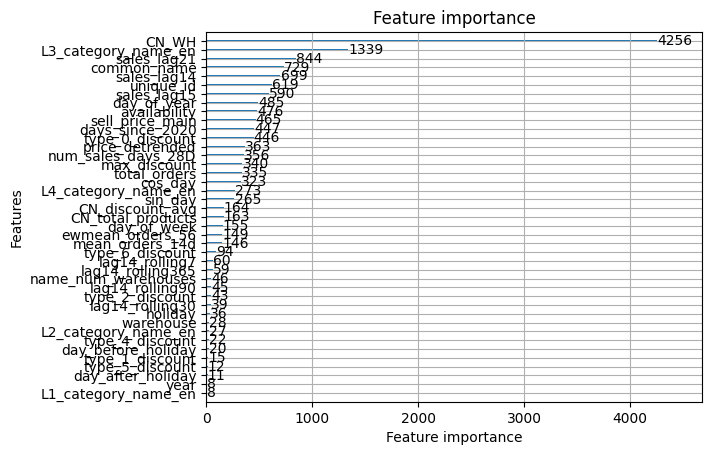

In [25]:
lgb.plot_importance(model)

In [24]:
%%time
test_predictions = lgb_model.predict(test[features])

CPU times: user 1.4 s, sys: 15.4 ms, total: 1.41 s
Wall time: 215 ms


In [26]:
submission = pd.concat([pd.Series(test.index), pd.Series(test_predictions**2)], axis=1)
submission.columns = ['id', 'sales_hat']
submission.to_csv('./submission.csv', index=False)

## XGBoost

In [ ]:
def xgb_mae(preds, dtrain):
    labels = dtrain.get_label()
    
    weights = dtrain.get_weight()
    if weights is None or len(weights) == 0:
        weights = np.ones_like(labels)
    
    squared_preds = preds ** 2
    squared_labels = labels ** 2
    # squared_preds = preds
    # squared_labels = labels
    
    weighted_mae = np.sum(np.abs(squared_preds - squared_labels) * weights) / np.sum(weights)
    return ('mae', weighted_mae)

In [ ]:

add_cols = ['last_sales_ema005','CN_sales_sum','last_sales_zs']
features = [col for col in train.columns if col not in ['date', 'name', 'sales'] + add_cols]

# Create DMatrix for training and validation
dtrain = xgb.DMatrix(train[features], label=np.sqrt(train['sales']), weight=train_weight, enable_categorical=True)
dvalid = xgb.DMatrix(val[features], label=np.sqrt(val['sales']), weight=test_weight, enable_categorical=True)

# Define XGBoost parameters (adjusted for GPU usage and analogous settings)
params = {
    'objective': 'reg:squarederror',  # regression objective
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'seed': 40,
    'device': 'cuda',
    'reg_lambda':0,
    'min_child_weight':1,
    'colsample_bytree': 0.8,
}

# Define a watchlist to monitor training and validation performance
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=watchlist,
    early_stopping_rounds=100,
    custom_metric=xgb_mae,
    verbose_eval=100
)

In [ ]:
# 4:06 start

In [ ]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain')